## Diagnostic tests for MOOC item response matrices

In [1]:
# Standard library imports
import os
from collections import defaultdict

In [2]:
# Data analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

### Pre-processing
Retrieve list of courses. Define measure names. Read in CSVs for all course-measure pairs.

In [51]:
# Data directories-- may need to adjust these
home = os.path.expanduser('~')
data_dir = home + "/Code/irt/data/"
course_list_dir = "done_courses.txt"

# Read in course list
courses = []
with open(data_dir + course_list_dir) as c_list:
    for course in c_list:
        courses.append(course.replace('/', '_').rstrip())

# Measures computed
measures = ['first_view', 'first_attempt', 'last_attempt', 'time_to_first_attempt', 'time_to_last_attempt',
            'time_spent_attempting', 'n_attempts', 'first_grade', 'last_grade']

# Data-framed CSVs of computed measures
data = defaultdict(dict)
for course in courses:
    for measure in measures:
        data[course][measure] = pd.read_csv(data_dir + "/exports/%s/%s.csv" % (course, measure), index_col=0)

### Test 1: Problem order check

First, we want to sanity check our first_view data against a total ordering of the items.

We'd expect to see a relatively smooth (but not necessarily monotonic) decrease in the attempt count as we progress through the course.



problem_id
z100                                  0
z102                                  1
z104                                  2
z112                                  3
z114                                  4
z116                                  5
z171                                  6
z173                                  7
z175                                  8
z33                                   9
z34                                  10
z40                                  11
z42                                  12
z44                                  13
z54                                  14
z56                                  15
z65                                  16
z67                                  17
z69                                  18
z78                                  19
z80                                  20
z82                                  21
z89                                  22
z91                                  23
z93                          

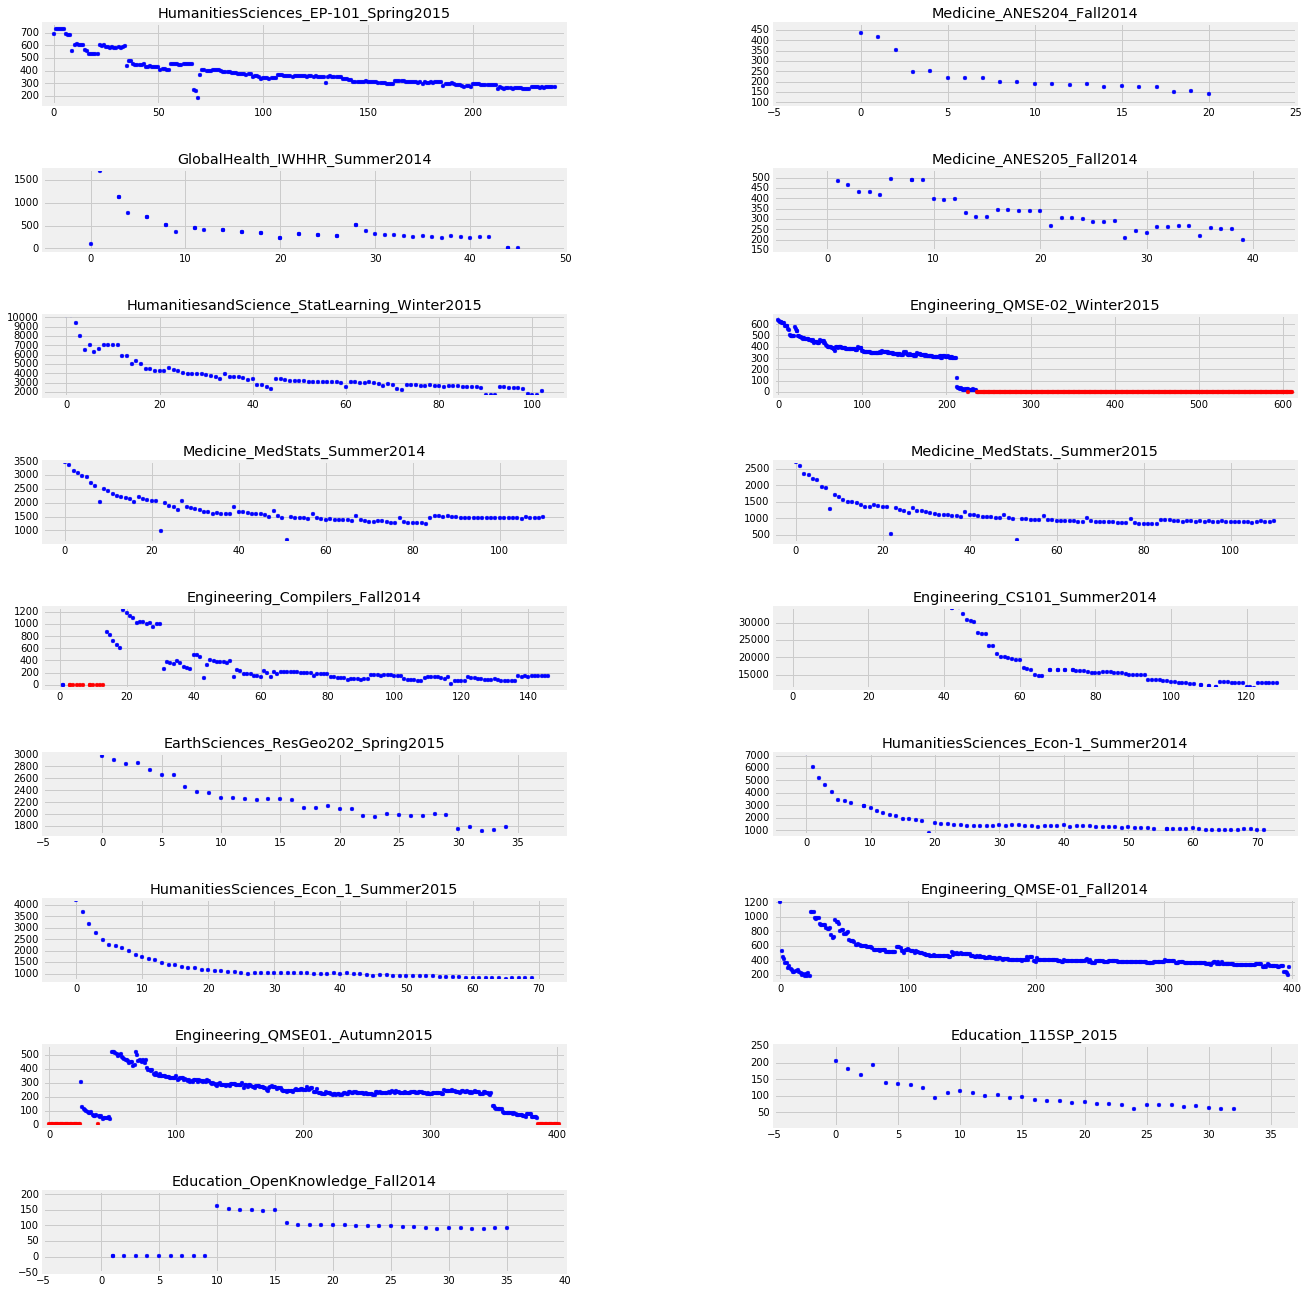

In [72]:
# Set up plots
fig = plt.figure(figsize=(20,25))
plt.subplots_adjust(hspace=0.8, wspace=0.4)

for idx, course in enumerate(courses):
    # Get total number of learners who saw each item and ordering of items in the course
    fv = data[course]['first_view']
    view_counts = fv.count().sort_values(ascending=False)
    item_metadata = pd.read_csv(data_dir + "/raws/%s_ProblemMetadata.csv" % course, index_col = 0)
    
    # Add attempt count to metadata for each item
    ncol = {}
    zeros = {}
    # print course
    for item in item_metadata.index:
        iuri = [pid for pid in view_counts.keys() if item in pid]
        if not iuri:
            # print item + " dropped at context " + item_metadata['context'][item] + " -- not attempted"
            zeros[item] = 1
            continue
        ncol[item] = view_counts[iuri[0]]
    item_metadata['view_count'] = pd.Series(ncol, item_metadata.index)
    item_metadata['zeros'] = pd.Series(zeros, item_metadata.index)
    
    # Add numerical rank to metadata for each item
    rank = {}
    r = 0
    for item in item_metadata.index:
        rank[item] = r
        r += 1
    item_metadata['total_order'] = pd.Series(rank, item_metadata.index)

    # Plot item order in course against number of learners who viewed each item
    ordering = item_metadata['total_order']
    views = item_metadata['view_count']
    dropped = item_metadata['zeros']
    subplot = fig.add_subplot(10,2,idx+1)
    subplot.set_title(course)
    plt.scatter(x=ordering, y=views, s=14, color='b')
    plt.scatter(x=ordering, y=dropped, s=14, color='r')
    xdelt = 5
    ydelt = 50
    plt.xlim(-xdelt, ordering.max()+xdelt)
    plt.ylim(views.min()-ydelt, views.max()+ydelt)